# HRD Status vs. PARP Inhibitor Response 

**Objective**: Systematically explore the relationship between homologous recombination deficiency (HRD) status and PARP inhibitor response across DepMap's cancer cell lines.

---
---
---

## 1. Setup 📦

---
---

In [1]:
# Data Management
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import ptitprince as pt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

# Computational Modules
from scipy.stats import mannwhitneyu, pearsonr, spearmanr, ttest_ind
from sklearn.preprocessing import RobustScaler, StandardScaler
import statsmodels.formula.api as smf

# Utils
from IPython.display import display, HTML, IFrame, Image
from pathlib import Path

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None)
sns.set_style('darkgrid', {'grid.color':'0.9','xtick.bottom':True,'ytick.left':True})

## 2. Data Loading ⚙️

**Objective**: Load the pickled, analysis-ready datasets containing PARP inhibitor response metrics and HRD features.

---
---

In [2]:
# Define project root & load analysis-ready dataset
BASE_DIR = Path.cwd()
ccl_hrd_parpi_df = pd.read_pickle(BASE_DIR / 'utils' / 'ccl_hrd_parpi_df.pkl')

ccl_hrd_parpi_df.head(5)

,ModelID,PARP_inhibitor,AUC,HRD_status,HRD_status_strict,hrd_BRCA,hrd_proxy,hrd_score_pct,hrd_score_std,hrd_SBS3,OncotreeLineage,OncotreePrimaryDisease,OncotreeSubtype,target,Age,AgeCategory,Sex,PatientRace,PrimaryOrMetastasis,GrowthPattern,indication,r2,BRCA2_damaging,BRCA1_damaging,BRCA1_cnloss_log2,BRCA2_cnloss_log2,BRCA1_loh_flag,BRCA2_loh_flag,BRCA1_homdel_flag,BRCA2_homdel_flag,BRCA1_double_hit,BRCA2_double_hit,BRCA_double_hit,BRCA_homdel,proxy_HRD_genomic_score,hrdsum_summary,SBS3,scaled_AUC
0,ACH-000001,niraparib,0.741783,1,0,0.0,1,1,0,0,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,PARP1,60.0,Adult,Female,caucasian,Metastatic,Adherent,primary peritoneal cancer (PPC),0.876853,0.0,0.0,0.752341,0.722099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.395118,32.0,NaN,-1.487580
1,ACH-000001,olaparib,0.916763,1,0,0.0,1,1,0,0,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,"PARP1, PARP2",60.0,Adult,Female,caucasian,Metastatic,Adherent,ovarian cancer,0.822464,0.0,0.0,0.752341,0.722099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.395118,32.0,NaN,0.060613
2,ACH-000001,rucaparib,0.828451,1,0,0.0,1,1,0,0,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,"PARP1, PARP2",60.0,Adult,Female,caucasian,Metastatic,Adherent,None,0.797532,0.0,0.0,0.752341,0.722099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.395118,32.0,NaN,-0.820746
3,ACH-000001,talazoparib,0.537748,1,0,0.0,1,1,0,0,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,PARP2,60.0,Adult,Female,caucasian,Metastatic,Adherent,None,0.966008,0.0,0.0,0.752341,0.722099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.395118,32.0,NaN,-0.670326
4,ACH-000013,niraparib,0.596983,1,0,0.0,1,1,0,0,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,PARP1,60.0,Adult,Female,caucasian,Metastatic,Adherent,primary peritoneal cancer (PPC),0.768993,0.0,0.0,0.836582,0.788146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.215191,30.0,NaN,-3.126786


`ccl_hrd_parpi_df` contains harmonized DepMap cancer cell line metadata alongside QC-filtered PARP inhibitor response measurements (`AUC`). The dataset is restricted to clinically approved PARP inhibitors used for their approved indications, ensuring this study tests for biological and translational relevance.

In addition to drug response data, the dataframe includes integrated HRD labels derived from BRCA alterations, genomic scar–based HRD scores, and SBS3 mutational signature exposure, as well as relevant contextual annotations for each cell line. This unified structure enables systematic evaluation of HRD status in relation to PARP inhibitor sensitivity across models.

## 3. Advanced Explorations & Final Preprocessing 🔍

**Objective**: Examine total cell lines, drug coverage, HRD definitions, and other key features to establish a foundational understanding of the engineered dataset and execute any remaining preprocessing steps.

**Methodology**: First, the integrated PARP inhibitor response dataset is loaded and inspected to confirm structural integrity, including dimensions, identifiers, and variable types. Second, the cohort composition is characterized by quantifying drug coverage across compounds and within cell lines to evaluate comparability and patterns of missingness. Third, baseline response behavior is examined through distributional summaries and dispersion metrics, establishing the scale, variability, and heterogeneity of AUC measurements prior to HRD-stratified analyses. Lastly, the drug response data is scaled to enable cross-inhibitor comparisons.

---
---

### 3a. Dataset Inspection

---

In [3]:
ccl_hrd_parpi_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 376 entries, 0 to 375
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   ModelID                  376 non-null    object  
 1   PARP_inhibitor           376 non-null    category
 2   AUC                      376 non-null    float64 
 3   HRD_status               376 non-null    int64   
 4   HRD_status_strict        376 non-null    int64   
 5   hrd_BRCA                 330 non-null    float64 
 6   hrd_proxy                376 non-null    int64   
 7   hrd_score_pct            376 non-null    int64   
 8   hrd_score_std            376 non-null    int64   
 9   hrd_SBS3                 376 non-null    int64   
 10  OncotreeLineage          376 non-null    category
 11  OncotreePrimaryDisease   376 non-null    object  
 12  OncotreeSubtype          376 non-null    object  
 13  target                   376 non-null    object  
 14  Age            

The dataset contains 376 rows, each representing a unique cell line–PARP inhibitor pairing. The records include drug response measurements, contextual annotations, and multiple independently engineered HRD features.

**Cell Line Identifier & Drug Response**:

| Feature        | Description                                                                          |
| :------------- | :----------------------------------------------------------------------------------- |
| ModelID        | Unique DepMap identifier for each cancer cell line                                   |
| PARP_inhibitor | Compound name                                                                        |
| AUC            | Area under the PRISM dose–response curve (lower values indicate greater sensitivity) |
| r2             | Goodness-of-fit metric for the logistic dose–response curve                          |
| target         | Molecular target annotation for the compound                                         |
| indication     | Approved clinical indication associated with the drug                                |



**Patient Demographics**:

| Feature     | Description                                |
| :---------- | :----------------------------------------- |
| Age         | Age at sampling                            |
| AgeCategory | Categorical grouping (Adult vs. Pediatric) |
| Sex         | Reported biological sex                    |
| PatientRace | Reported race                              |



**Disease & Model Annotation**:

| Feature                | Description                                 |
| :--------------------- | :------------------------------------------ |
| OncotreeLineage        | Broad tumor lineage classification          |
| OncotreePrimaryDisease | Primary disease label                       |
| OncotreeSubtype        | Histologic or molecular subtype             |
| PrimaryOrMetastasis    | Tumor origin status                         |
| GrowthPattern          | Culture format (e.g., adherent, suspension) |


**HRD Features** (Engineered Across Notebooks 2-6):

| HRD Category                       | Feature                                | Description                                                      |
| :--------------------------------- | :------------------------------------- | :--------------------------------------------------------------- |
| **Overall HRD Status**             | HRD_status                             | Unified HRD label (uses pct-based threshold of HRD score)        |
|                                    | HRD_status_strict                      | Unified HRD label (uses std-based threshold of HRD score)        |
| **BRCA-Defined HRD**               | hrd_BRCA                               | Primary BRCA-based HRD label (double-hit or homozygous deletion) |
|                                    | BRCA1_damaging, BRCA2_damaging         | Damaging somatic mutations                                       |
|                                    | BRCA1_cnloss_log2, BRCA2_cnloss_log2   | Copy number loss (log2 scale)                                    |
|                                    | BRCA1_loh_flag, BRCA2_loh_flag         | Loss-of-heterozygosity indicators                                |
|                                    | BRCA1_homdel_flag, BRCA2_homdel_flag   | Homozygous deletion flag                                         |
|                                    | BRCA1_double_hit, BRCA2_double_hit     | Gene-specific double-hit status (damaging mutation + LOH)        |
|                                    | BRCA_double_hit                        | Combined BRCA1/2 double-hit indicator                            |
|                                    | BRCA_homdel                            | Combined BRCA homozygous deletion flag                           |
| **Genomic Scar–Based HRD Scores**  | hrdsum_summary                         | Continuous HRD genomic scar score                                |
|                                    | hrd_score_pct                          | Binary flag based on 75th percentile threshold                   |
|                                    | hrd_score_std                          | Binary flag based on mean + 2xSD threshold                       |
| **Proxy HRD Score**                | proxy_HRD_genomic_score                | Alternative genomic score (from v1)                              |
|                                    | hrd_proxy                              | Binary proxy HRD status (from v1)                                |
| **Mutational Signature–Based HRD** | SBS3                                   | SBS3 exposure value                                              |
|                                    | hrd_SBS3                               | Binary SBS3-derived HRD label                                    |

### 3b. Cell Lines & Drug Coverage

---

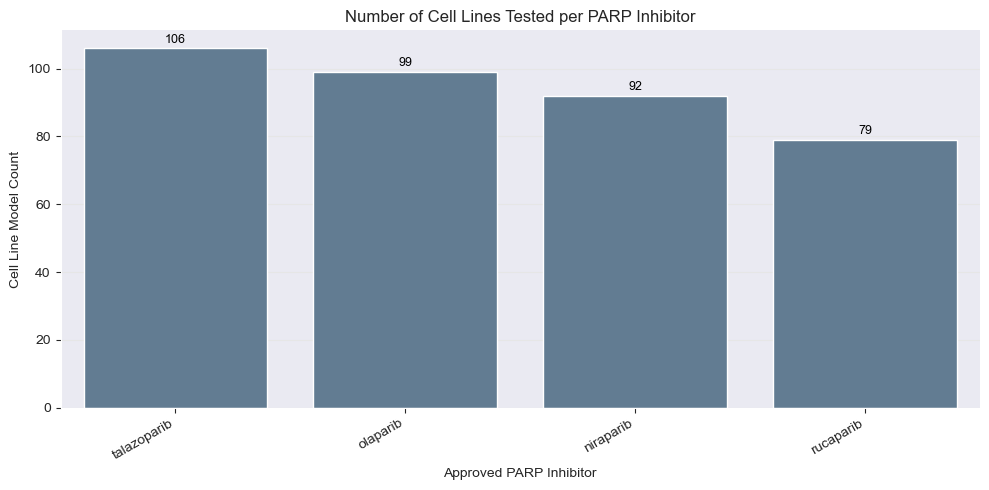

In [4]:
# Set up figure 
plt.figure(figsize=(10, 5))

# Plot number of cells tested per drug
ax = sns.countplot(
    data=ccl_hrd_parpi_df,
    x='PARP_inhibitor',
    order=(ccl_hrd_parpi_df['PARP_inhibitor'].value_counts().sort_values(ascending=False).index),
    color='#5A7D9A'
)

# Add count labels on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{int(height)}',
        (p.get_x() + p.get_width() / 2., height),
        ha='center',
        va='bottom',
        fontsize=9,
        color='black',
        xytext=(0, 2),
        textcoords='offset points'
    )

# Labels and formatting
ax.set_title('Number of Cell Lines Tested per PARP Inhibitor')
ax.set_xlabel('Approved PARP Inhibitor')
ax.set_ylabel('Cell Line Model Count')
plt.xticks(rotation=30, ha='right')
sns.despine()
plt.tight_layout()
plt.show()

Drug representation across the screening panel is moderately imbalanced. **Talazoparib**, **Olaparib**, and **Niraparib** were evaluated in the largest number of cell line models, whereas **Rucaparib** was tested in a comparatively smaller subset.

This imbalance directly affects inferential stability. Drugs with broader coverage offer increased statistical power, tighter variance estimates, and more reliable HRD–response comparisons. In contrast, compounds screened in fewer models are more susceptible to sampling variability and reduced sensitivity for detecting HRD-associated effects.

Accordingly, downstream analyses should explicitly account for coverage differences when pooling across compounds and when performing drug-specific stratifications, in order to avoid conflating biological signal with sample size artifacts.

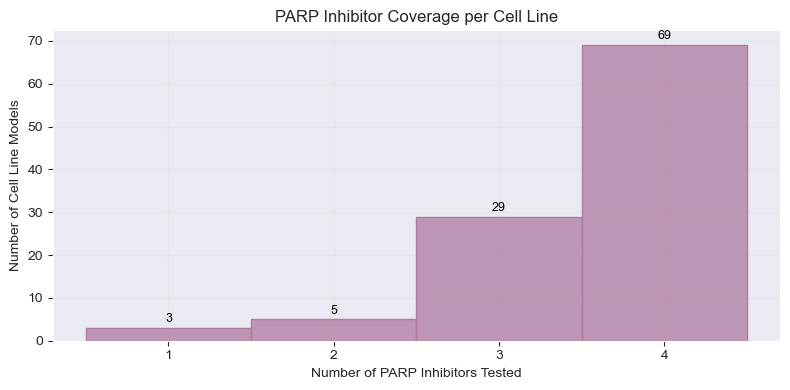

In [5]:
# Compute drug coverage per cell line
drug_counts = (
    ccl_hrd_parpi_df
    .groupby('ModelID')['PARP_inhibitor']
    .nunique()
    .reset_index(name='drug_count')
)


# Set up figure
plt.figure(figsize=(8, 4))

# Histogram with integer-aligned bins
ax = sns.histplot(
    data=drug_counts,
    x='drug_count',
    discrete=True,
    stat='count',
    color='#B07AA1',
    # kde=True,
    edgecolor='#B07AA1',
    alpha=0.75
)

# Add count labels on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{int(height)}',
        (p.get_x() + p.get_width() / 2., height),
        ha='center',
        va='bottom',
        fontsize=9,
        color='black',
        xytext=(0, 2),
        textcoords='offset points'
    )
     
# Labels and formatting
plt.title('PARP Inhibitor Coverage per Cell Line')
plt.xlabel('Number of PARP Inhibitors Tested')
plt.ylabel('Number of Cell Line Models')
plt.xticks(range(int(drug_counts['drug_count'].min()),
                 int(drug_counts['drug_count'].max()) + 1))
plt.tight_layout()
plt.show()

The distribution of unique PARP inhibitors tested per cell line is shown above. Because coverage is a discrete integer quantity, the histogram uses one bin per compound, enabling direct interpretation of screening depth. Most cell lines were evaluated against a large fraction of the PARP inhibitor panel. The distribution is right-skewed toward higher coverage: 69 models were tested against all 4 compounds, 29 against 3 compounds, 5 against 2 compounds, and only 3 against a single compound. This results in a sparse low-coverage tail.

This structure supports cross-drug comparisons in the majority of models. Broadly screened cell lines enable within-model assessment of relative drug sensitivity, reducing confounding from inter-model variability. In contrast, partially profiled models introduce additional missingness and may inflate variance in drug-specific analyses. Accordingly, downstream modeling may benefit from sensitivity analyses restricted to fully or near-fully screened cell lines to confirm the robustness of HRD–response associations.

### 3c. HRD Landscape Across the Screen

---

#### Overall HRD Prevalence By Definition

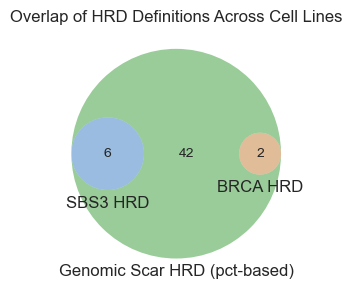

In [6]:
# Collapse to unique cell line–level HRD labels
hrd_summary = (
    ccl_hrd_parpi_df
    .groupby('ModelID')[['hrd_BRCA', 'hrd_score_pct', 'hrd_SBS3']]
    .max()  
    .reset_index()
)

# Create sets of HRD-positive models for each definition
brca_set = set(hrd_summary.loc[hrd_summary['hrd_BRCA'] == 1, 'ModelID'])
scar_set = set(hrd_summary.loc[hrd_summary['hrd_score_pct'] == 1, 'ModelID'])
sbs3_set = set(hrd_summary.loc[hrd_summary['hrd_SBS3'] == 1, 'ModelID'])

# Visualize overlap between both HRD definitions
plt.figure(figsize=(3, 3))
venn3(
    [brca_set, scar_set, sbs3_set],
    set_labels=('BRCA HRD', 'Genomic Scar HRD (pct-based)', 'SBS3 HRD')
)
plt.title('Overlap of HRD Definitions Across Cell Lines')
plt.tight_layout()
plt.show()

The Venn diagram demonstrates that genomic scar–defined HRD (75pct threshold) captures the broadest set of models (n = 42). All BRCA-defined HRD models (n = 2) and all SBS3-positive models (n = 6) fall entirely within this genomic scar–positive group.

Importantly, there are no models uniquely classified as HRD by BRCA mutation status or SBS3 exposure alone. Instead, these definitions represent nested subsets of the broader genomic scar cohort. This suggests that, within this dataset, the genomic scar metric is the most inclusive HRD classifier, while BRCA double-hit status and SBS3 exposure identify more stringent or biologically specific subpopulations.

The structure implies that genomic scar–based HRD may serve as a sensitive screening definition, whereas BRCA and SBS3 labels reflect narrower mechanistic subsets within that group.

#### HRD Definitions Concordance

In [7]:
# BRCA vs Genomic Scar
concordance_brca_scar = pd.crosstab(
    hrd_summary['hrd_BRCA'],
    hrd_summary['hrd_score_pct'],
    rownames=['BRCA'],
    colnames=['Genomic Scar (75th pct)']
)

# BRCA vs SBS3
concordance_brca_sbs3 = pd.crosstab(
    hrd_summary['hrd_BRCA'],
    hrd_summary['hrd_SBS3'],
    rownames=['BRCA'],
    colnames=['SBS3']
)

# Genomic Scar vs SBS3
concordance_scar_sbs3 = pd.crosstab(
    hrd_summary['hrd_score_pct'],
    hrd_summary['hrd_SBS3'],
    rownames=['Genomic Scar (75th pct)'],
    colnames=['SBS3']
)

print(concordance_brca_scar)
print()
print(concordance_brca_sbs3)
print()
print(concordance_scar_sbs3)

Genomic Scar (75th pct)   0   1
BRCA                           
0.0                      45  45
1.0                       0   2

SBS3   0  1
BRCA       
0.0   84  6
1.0    2  0

SBS3                      0  1
Genomic Scar (75th pct)       
0                        56  0
1                        44  6


The pairwise concordance tables highlight clear asymmetry in how the three HRD definitions overlap.

**BRCA vs. Genomic Scar (pct-based)**
Both BRCA-defined HRD models are also genomic scar–positive. However, genomic scar positivity is much broader: 45 additional models are scar-positive but BRCA-wildtype. This confirms that BRCA double-hit status represents a small, fully nested subset within the larger scar-defined HRD population.

**BRCA vs. SBS3**
There is no overlap between BRCA-defined HRD and SBS3-defined HRD. The 2 BRCA-positive models are SBS3-negative, while 6 SBS3-positive models are BRCA-wildtype. This suggests that, in this dataset, SBS3 exposure identifies a mechanistically distinct subset that does not coincide with BRCA double-hit events.

**Genomic Scar vs. SBS3**
All SBS3-positive models (6/6) are also genomic scar–positive. No SBS3 signal is observed in scar-negative models. However, most scar-positive models (44/50) are SBS3-negative, indicating that genomic scar positivity is substantially more inclusive.

The genomic scar definition is the most sensitive and inclusive HRD classifier in this cohort. Both BRCA-defined HRD and SBS3-defined HRD are entirely nested within the scar-positive group, but they do not overlap with each other. This pattern suggests that genomic scar status captures a broad HRD phenotype while BRCA double-hit and SBS3 exposure identify narrower, biologically distinct subsets within that broader scar-defined group. No evidence supports BRCA and SBS3 convergence in this screen.

Together, these results reinforce the role of genomic scar–based HRD as a unifying backbone definition, with BRCA and SBS3 acting as more specific mechanistic refinements.

#### HRD Frequency by Cancer Lineage

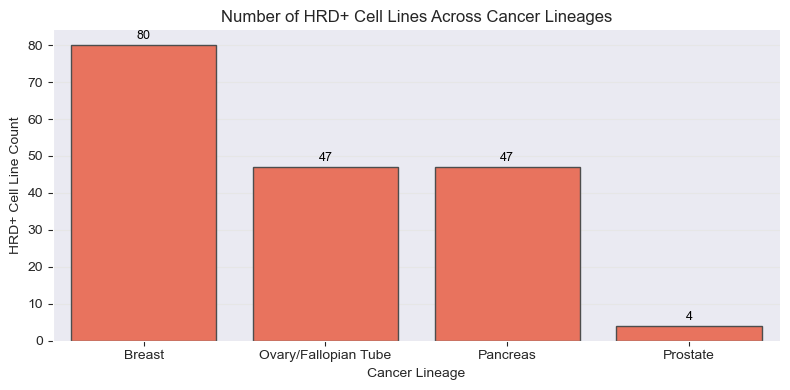

In [8]:
# Compute total HRD+ cell line counts per lineage
lineage_hrd_counts = (
    ccl_hrd_parpi_df
    .groupby('OncotreeLineage', observed=False)['HRD_status']
    .sum() 
    .reset_index(name='hrd_count')
    .sort_values('hrd_count', ascending=False)
)

# Set up figure
plt.figure(figsize=(8, 4))

# Barplot
ax = sns.barplot(
    data=lineage_hrd_counts,
    x='OncotreeLineage',
    y='hrd_count',
    color='tomato',  
    edgecolor=(0.3, 0.3, 0.3, 0.5),
    alpha=1
)

# Add count labels on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{int(height)}',
        (p.get_x() + p.get_width() / 2., height),
        ha='center',
        va='bottom',
        fontsize=9,
        color='black',
        xytext=(0, 2),
        textcoords='offset points'
    )

# Labels and formatting
plt.title('Number of HRD+ Cell Lines Across Cancer Lineages')
plt.xlabel('Cancer Lineage')
plt.ylabel('HRD+ Cell Line Count')
sns.despine()
plt.tight_layout()
plt.show()

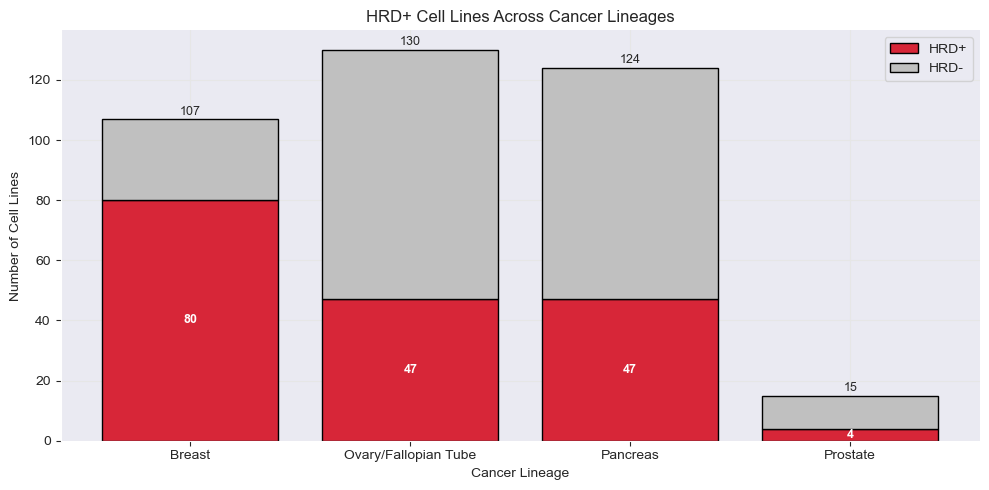

In [9]:
# Compute counts of HRD+ and HRD- per lineage
lineage_counts = (
    ccl_hrd_parpi_df
    .groupby(['OncotreeLineage', 'HRD_status'], observed=False)
    .size()
    .unstack(fill_value=0)  # HRD_status: 0 = non-HRD, 1 = HRD+
    .reset_index()
)

# Rename columns and sort for plotting convenience
lineage_counts.columns = ['OncotreeLineage', 'HRD-', 'HRD+']
lineage_counts = lineage_counts.sort_values('HRD+', ascending=False)

# Set up figure
plt.figure(figsize=(10, 5))

# Bottom Portion: HRD+
plt.bar(
    lineage_counts['OncotreeLineage'],
    lineage_counts['HRD+'],
    color='#D72638',
    edgecolor='k',
    label='HRD+'
)

# Top Portion: HRD-
plt.bar(
    lineage_counts['OncotreeLineage'],
    lineage_counts['HRD-'],
    bottom=lineage_counts['HRD+'],
    color='silver',
    edgecolor='k',
    label='HRD-'
)

# Add count labels for HRD+ portion
for idx, row in lineage_counts.iterrows():
    plt.text(
        idx,
        row['HRD+'] / 2,   # show in middle of HRD+ portion
        f'{row["HRD+"]}',
        ha='center',
        va='center',
        fontsize=9,
        color='white',
        fontweight='bold'
    )
# Add total count labels
for idx, row in lineage_counts.iterrows():
    total = row['HRD-'] + row['HRD+']
    plt.text(
        idx,
        total + 0.5,
        f'{total}',
        ha='center',
        va='bottom',
        fontsize=9
    )

# Labels and formatting
plt.xlabel('Cancer Lineage')
plt.ylabel('Number of Cell Lines')
plt.title('HRD+ Cell Lines Across Cancer Lineages')
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

The stacked barplot shows the distribution of HRD-positive (`HRD+`) and HRD-negative (`HRD−`) cell lines across major cancer lineages. Breast cancer has the highest HRD prevalence  (**80/107**), followed by ovarian/fallopian tube (**47/130**) and pancreatic (**47/124**). Prostate has very few cell lines in general and therefore a low HRD+ count (**4/15**).

This highlights two key points: first, HRD is highly enriched in specific lineages (breast, ovarian, pancreas), and second, the absolute number of models varies substantially across lineages. Lineages with small sample sizes, like prostate, will have limited power for lineage-specific HRD analyses.

Stacking HRD+ on the bottom emphasizes the proportion of HRD-positive models while preserving total lineage counts. This structure allows direct visual assessment of both prevalence and screening depth, which is critical for interpreting lineage-specific drug response analyses.


### 3d. Drug Response Metric (AUC) Characteristics

---

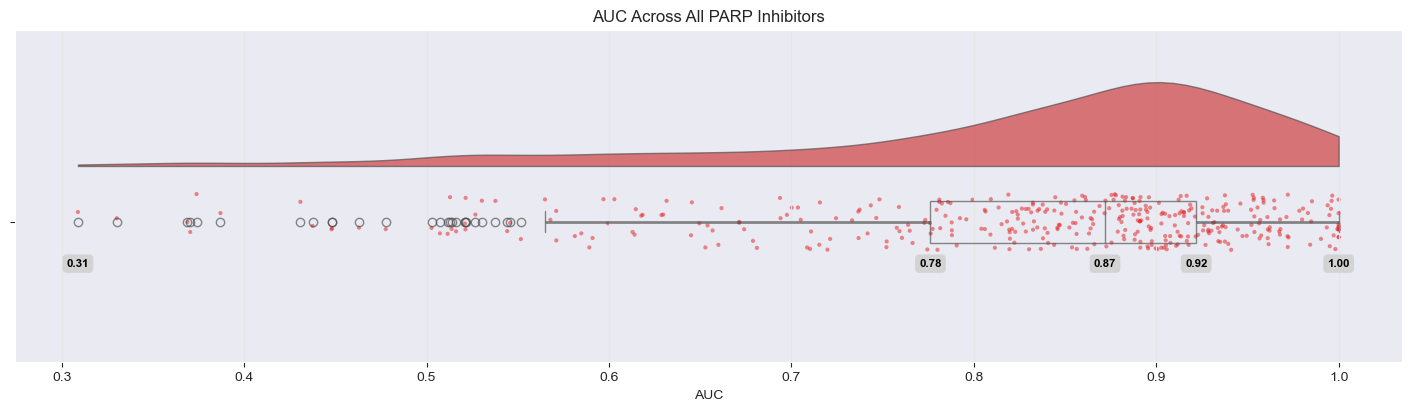

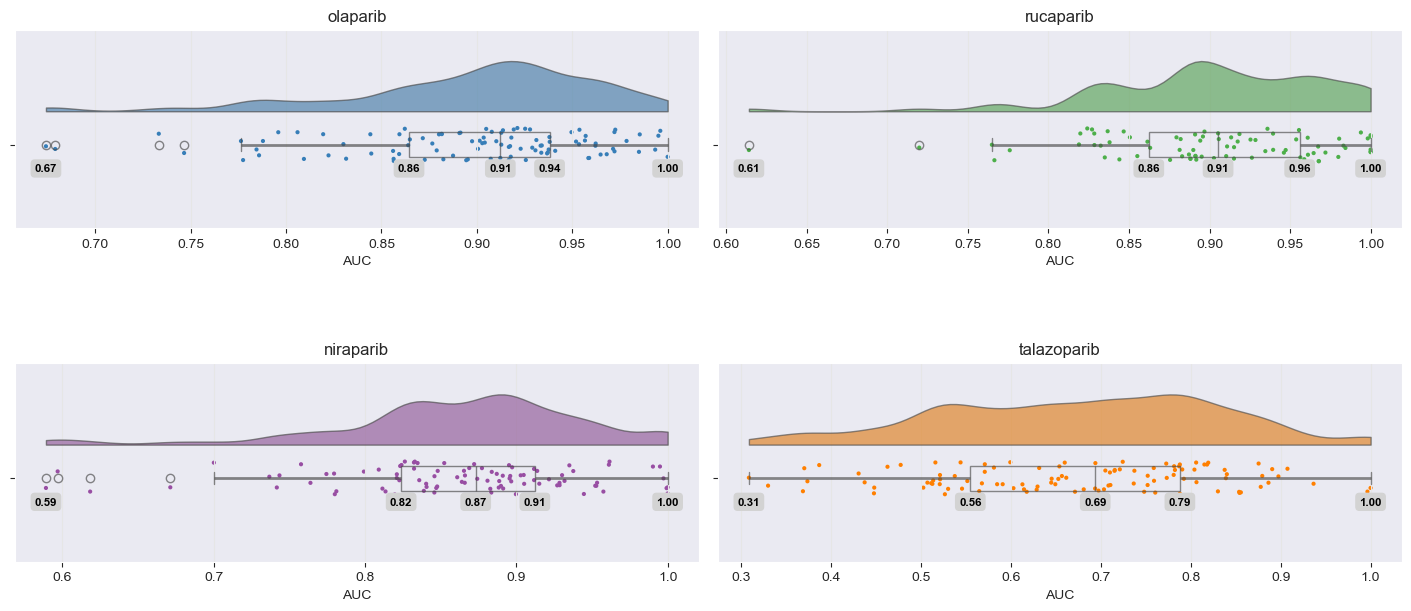

In [10]:
# Set up figure & individual subplots
fig, axs = plt.subplots(1, 1, figsize=(14, 4), 
    layout='constrained', gridspec_kw={'hspace': 0.25})
rc_palettes = sns.color_palette('Set1', n_colors=14)

# Plot AUCs across all drugs
cloud_all = pt.RainCloud(
    data=ccl_hrd_parpi_df,
    y='AUC',
    bw=0.2,
    alpha=0.65,
    rain_alpha=0.5,
    width_viol=0.6,
    orient='h',
    palette=[rc_palettes[0]],
    hue=0,
    ax=axs,
)

# Add quartile labels
desc_stats = ccl_hrd_parpi_df['AUC'].quantile([0, 0.25, 0.5, 0.75, 1])
for stat in desc_stats:
    cloud_all.text(
        s=f"{stat:.2f}",
        x=stat,
        y=0.16,
        ha='center',
        size='small',
        color='black',
        weight='semibold',
        bbox=dict(facecolor='lightgray', edgecolor='lightgray', linewidth=1, fill=True, boxstyle='round')
    )
axs.set_title('AUC Across All PARP Inhibitors')

##################################################

# Set up figure & individual subplots for drugs
fig, axs = plt.subplots(2, 2, figsize=(14, 6), 
    layout='constrained', gridspec_kw={'hspace': 0.25})
axs = axs.flatten()  # for easy indexing
rc_palettes = sns.color_palette('Set1', n_colors=14)

# Define the new drug order
drug_list = ['olaparib', 'rucaparib', 'niraparib', 'talazoparib']

# Plot AUCs for each drug
for i, drug in enumerate(drug_list):
    
    # Subset for specific drug
    drug_data = ccl_hrd_parpi_df[ccl_hrd_parpi_df['PARP_inhibitor'] == drug]

    # Raincloud
    cloud = pt.RainCloud(
        data=drug_data,
        y='AUC',
        bw=0.2,
        alpha=0.65,
        rain_alpha=1,
        width_viol=0.6,
        orient='h',
        hue=i,
        palette=[rc_palettes[i+1]],
        ax=axs[i],
    )

    # Add quartile labels
    desc_stats = drug_data['AUC'].quantile([0, 0.25, 0.5, 0.75, 1])
    for stat in desc_stats:
        cloud.text(
            s=f"{stat:.2f}",
            x=stat,
            y=0.16,
            ha='center',
            size='small',
            color='black',
            weight='semibold',
            bbox=dict(facecolor='lightgray', edgecolor='lightgray', linewidth=1, fill=True, boxstyle='round')
        )
    axs[i].set_title(drug)

plt.show()

PRISM AUC distributions for all PARP inhibitors and pooled across compounds. Lower AUC indicates higher sensitivity. The aggregated distribution is unimodal around 0.9, with a substantial right tail. Stratified by drug, most compounds show tightly clustered responses, while Talazoparib is more dispersed with resistant outliers. Rucaparib and Niraparib show slight multimodal patterns, potentially reflecting biologically distinct subgroups. These differences in median, variance, and tail structure highlight that PARP inhibitors are not interchangeable and underscore the need for HRD-stratified analyses.

#### Drug Response Dispersion 

In [11]:
# Group by drug and compute variability metrics
drug_dispersion_df = (
    ccl_hrd_parpi_df
    .groupby('PARP_inhibitor', observed=False)['AUC']
    .agg(
        n_models='count',
        mean_auc='mean',
        std_auc='std',
        min_auc='min',
        max_auc='max'
    )
)

# Compute coefficient of variation
drug_dispersion_df['cv'] = drug_dispersion_df['std_auc'] / drug_dispersion_df['mean_auc']

# Apply a robust dynamic range (less sensitive to extreme outliers)
percentiles = (
    ccl_hrd_parpi_df
    .groupby('PARP_inhibitor', observed=False)['AUC']
    .quantile([0.05, 0.95])  # for initial explorations
    .unstack()
    .rename(columns={0.05: 'p05', 0.95: 'p95'})
)

drug_dispersion_df = drug_dispersion_df.join(percentiles)
drug_dispersion_df['dynamic_range_95_5'] = (
    drug_dispersion_df['p95'] - drug_dispersion_df['p05']
)

# Rank by separation ability
drug_dispersion_df = drug_dispersion_df.sort_values(
    by='dynamic_range_95_5',
    ascending=False
)

drug_dispersion_df.round(3)

,n_models,mean_auc,std_auc,min_auc,max_auc,cv,p05,p95,dynamic_range_95_5
PARP_inhibitor,,,,,,,,,
talazoparib,106,0.675,0.156,0.309,1.0,0.231,0.398,0.896,0.498
niraparib,92,0.862,0.083,0.589,1.0,0.096,0.720,0.992,0.272
rucaparib,79,0.901,0.070,0.614,1.0,0.078,0.775,1.000,0.225
olaparib,99,0.898,0.067,0.674,1.0,0.074,0.777,0.985,0.208


The table quantifies how response variability differs across PARP inhibitors, revealing several important patterns.

Talazoparib exhibits the largest spread in response, with the highest dynamic range (0.498) and coefficient of variation, indicating substantial variability across cell lines. Niraparib shows moderate variability, while Rucaparib and Olaparib have narrower distributions, suggesting more consistent responses across the screened panel. The robust 5th–95th percentile range highlights that extreme outliers have minimal influence on these rankings. These dispersion metrics can guide the selection of drugs for downstream HRD–sensitivity analyses, prioritizing compounds with both broad coverage and measurable response variability.

Overall, these results reinforce a key message from the visualizations: PARP inhibitors differ widely in both potency and discriminatory capacity. Any cross-drug comparison or pooled analysis must account for compound-specific scaling and variance structure.

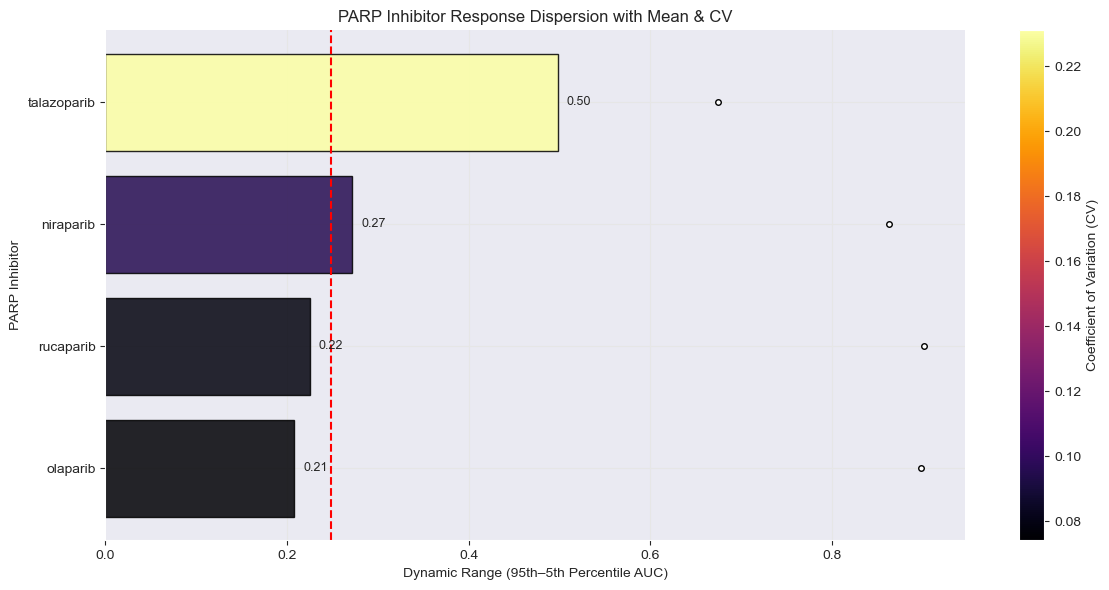

In [12]:
# Set up figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Normalize CV for color mapping
norm = plt.Normalize(drug_dispersion_df['cv'].min(), drug_dispersion_df['cv'].max())
cmap = plt.cm.inferno

# Bar plot with CV-based colors
bars = ax.barh(
    y=drug_dispersion_df.index,
    width=drug_dispersion_df['dynamic_range_95_5'],
    color=cmap(norm(drug_dispersion_df['cv'])),
    edgecolor='black',
    alpha=0.85
)

# Overlay mean AUC as a dot
for i, drug in enumerate(drug_dispersion_df.index):
    ax.plot(
        drug_dispersion_df.loc[drug, 'mean_auc'],
        i,
        'o',
        color='white',
        markersize=4,
        markeredgecolor='black'
    )

# Add numeric labels for dynamic range
for i, v in enumerate(drug_dispersion_df['dynamic_range_95_5']):
    ax.text(v + 0.01, i, f'{v:.2f}', va='center', fontsize=9)

# Add vertical line for median dynamic range
median_range = drug_dispersion_df['dynamic_range_95_5'].median()
ax.axvline(median_range, color='red', linestyle='--', linewidth=1.5, label=f'Median Range ({median_range:.2f})')

# Labels and formatting
ax.set_xlabel('Dynamic Range (95th–5th Percentile AUC)')
ax.set_ylabel('PARP Inhibitor')
ax.set_title('PARP Inhibitor Response Dispersion with Mean & CV')
ax.invert_yaxis()  # largest range on top
sns.despine(ax=ax)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Coefficient of Variation (CV)')

plt.tight_layout()
plt.show()

This plot above compares the effective response window of each PARP inhibitor. Bar length reflects the robust dynamic range between the 5th and 95th percentile AUCs, color encodes the relative variability across cell lines (coefficient of variation), and the white marker indicates the mean AUC for each compound.

Talazoparib shows the largest separation between sensitive and resistant models (dynamic range = 0.50) and the highest variability (CV = 0.23), highlighting its heterogeneous activity across the panel. Niraparib exhibits moderate spread (0.27) with lower variability, while Rucaparib (0.22) and Olaparib (0.21) have narrower, more consistent response distributions.

The vertical red dashed line denotes the median dynamic range across all compounds (~0.30), providing a reference for relative dispersion. This visualization emphasizes that Talazoparib captures the broadest spectrum of responses, which may enhance the detection of HRD-associated sensitivity differences, whereas the other drugs show tighter, more uniform effects.

### 3e. Scale Drug Response Metric (AUC) 

---

In [13]:
def scale_within_drug(df):
    """Applies robust scaling to input subset dataframe."""
    scaler = RobustScaler()
    df = df.copy()
    df['scaled_AUC'] = scaler.fit_transform(df[['AUC']])
    return df

# Apply scaling separately for each drug
ccl_hrd_parpi_df = (
    ccl_hrd_parpi_df
    .groupby(ccl_hrd_parpi_df.PARP_inhibitor.copy(), group_keys=False, observed=False)
    .apply(scale_within_drug, include_groups=False)
)

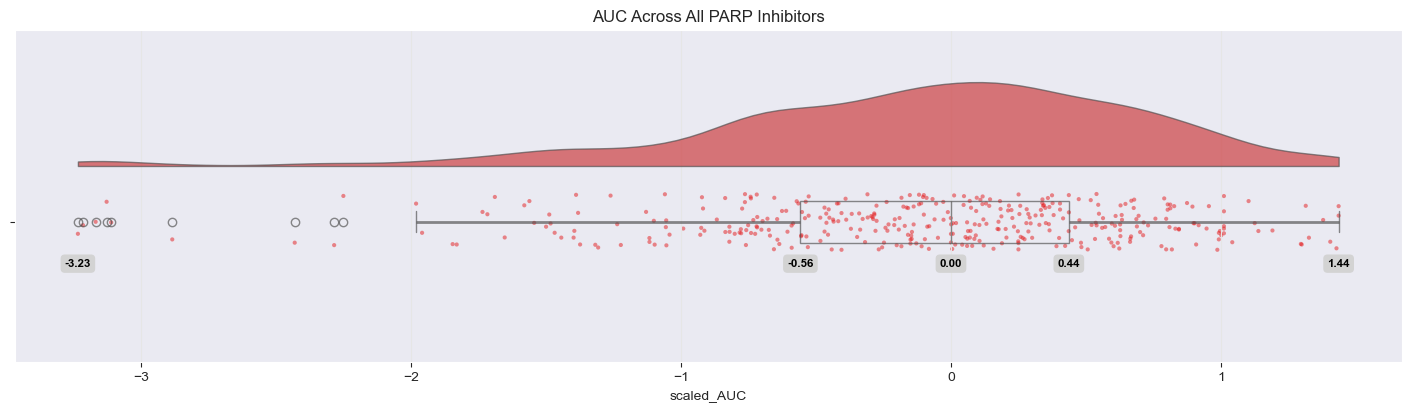

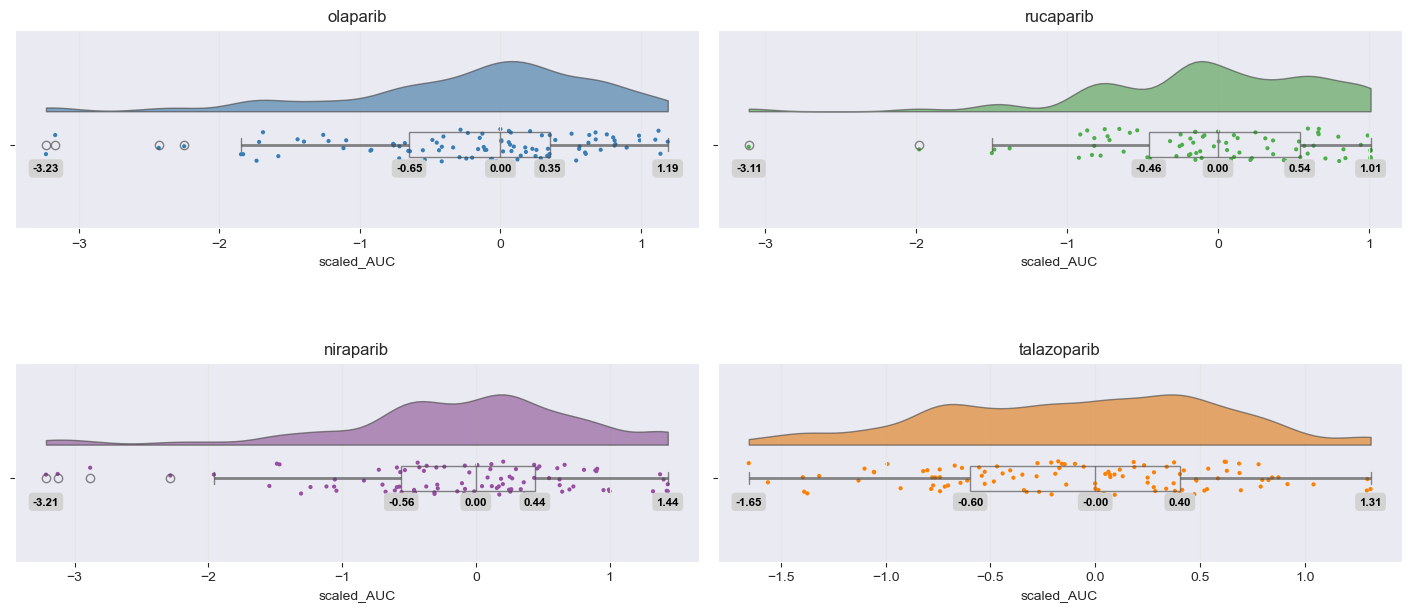

In [14]:
# Set up figure & individual subplots
fig, axs = plt.subplots(1, 1, figsize=(14, 4), 
    layout='constrained', gridspec_kw={'hspace': 0.25})
rc_palettes = sns.color_palette('Set1', n_colors=14)

# Plot AUCs across all drugs
cloud_all = pt.RainCloud(
    data=ccl_hrd_parpi_df,
    y='scaled_AUC',
    bw=0.2,
    alpha=0.65,
    rain_alpha=0.5,
    width_viol=0.6,
    orient='h',
    palette=[rc_palettes[0]],
    hue=0,
    ax=axs,
)

# Add quartile labels
desc_stats = ccl_hrd_parpi_df['scaled_AUC'].quantile([0, 0.25, 0.5, 0.75, 1])
for stat in desc_stats:
    cloud_all.text(
        s=f"{stat:.2f}",
        x=stat,
        y=0.16,
        ha='center',
        size='small',
        color='black',
        weight='semibold',
        bbox=dict(facecolor='lightgray', edgecolor='lightgray', linewidth=1, fill=True, boxstyle='round')
    )
axs.set_title('AUC Across All PARP Inhibitors')

##################################################

# Set up figure & individual subplots for drugs
fig, axs = plt.subplots(2, 2, figsize=(14, 6), 
    layout='constrained', gridspec_kw={'hspace': 0.25})
axs = axs.flatten()  # for easy indexing
rc_palettes = sns.color_palette('Set1', n_colors=14)

# Define the new drug order
drug_list = ['olaparib', 'rucaparib', 'niraparib', 'talazoparib']

# Plot AUCs for each drug
for i, drug in enumerate(drug_list):
    
    # Subset for specific drug
    drug_data = ccl_hrd_parpi_df[ccl_hrd_parpi_df['PARP_inhibitor'] == drug]

    # Raincloud
    cloud = pt.RainCloud(
        data=drug_data,
        y='scaled_AUC',
        bw=0.2,
        alpha=0.65,
        rain_alpha=1,
        width_viol=0.6,
        orient='h',
        hue=i,
        palette=[rc_palettes[i+1]],
        ax=axs[i],
    )

    # Add quartile labels
    desc_stats = drug_data['scaled_AUC'].quantile([0, 0.25, 0.5, 0.75, 1])
    for stat in desc_stats:
        cloud.text(
            s=f"{stat:.2f}",
            x=stat,
            y=0.16,
            ha='center',
            size='small',
            color='black',
            weight='semibold',
            bbox=dict(facecolor='lightgray', edgecolor='lightgray', linewidth=1, fill=True, boxstyle='round')
        )
    axs[i].set_title(drug)

plt.show()

Before proceeding, an additional preprocessing step was applied to enable fair comparisons of AUC values across PARP inhibitors. Each compound exhibits a distinct response distribution, so raw AUCs are not directly comparable across drugs.

To address this, robust scaling was applied within each drug. This transformation centers values at the median and scales them by the interquartile range (IQR), reducing the influence of outliers. Compared with standard z-score normalization, robust scaling is less sensitive to skewed or heavy-tailed distributions, which are observed for several inhibitors in this dataset.

Under this transformation, AUC values are now centered around zero, representing typical responses. Negative values indicate greater-than-typical sensitivity, and positive values indicate relative resistance. It is important to note, however, that a negative value does not automatically mean PARPi is sensitive. This process preserves the rank ordering of responses within each drug while placing compounds on a comparable relative scale and provides a more stable foundation for pooled HRD comparisons conducted later in the analysis.

## 4. Relationship Between HRD & PARP Inhibitor Sensitivity 🔬

**Objective**: Examine how PARP inhibitor response distributions differ between HRD-defined groups across drugs and disease contexts, and identify patterns that motivate formal effect quantification.

**Methodology**: First, global AUC distributions between HRD+ and HRD- models are compared using summary statistics, visualization, and non-parametric testing. Next, the comparison is repeated separately for each PARP inhibitor to determine whether associations are consistent or drug-specific. Finally, response differences are evaluated within tumor lineages to explore potential biological heterogeneity and to highlight contexts where HRD stratification may be most informative.

---

### 4a. Global Comparison

In [15]:
# Examine scaled auc stratified by HRD status
global_hrd_summary = (
    ccl_hrd_parpi_df
    .groupby('HRD_status')['AUC']
    .agg(['count', 'mean', 'median', 'std'])
)

global_hrd_summary

,count,mean,median,std
HRD_status,,,,
0,198,0.826957,0.865159,0.144576
1,178,0.826966,0.874995,0.138183


Across the full DepMap screening panel, AUC values show nearly identical averages between HRD+ and HRD- groups. HRD+ models (n = 178) have a mean scaled AUC of ~0.827 and a median of ~0.875, while HRD− models (n = 198) show a mean of ~0.827 and a median of ~0.865. Variability is slightly lower in the HRD+ subset (std of 0.138 vs. 0.145).

At this global level, there is no obvious shift in the central tendency of drug sensitivity between HRD-defined groups, suggesting that any HRD-associated effects may be subtle, drug-specific, or lineage-dependent rather than uniform across the panel. This motivates further stratified analyses by compound and cancer type.

In [16]:
# Subset HRD positive and negative cell lines
hrd_pos = ccl_hrd_parpi_df.loc[ccl_hrd_parpi_df['HRD_status']==1, 'AUC']
hrd_neg = ccl_hrd_parpi_df.loc[ccl_hrd_parpi_df['HRD_status']==0, 'AUC']

# Execute Mann-Whitney U Test
stat, p = mannwhitneyu(hrd_pos, hrd_neg, alternative='two-sided')
print(f'Mann-Whitney U p-value: {p:.4e}')

Mann-Whitney U p-value: 9.3600e-01


A Mann–Whitney U test was performed to compare the distributions of AUC values between HRD-positive (n = 178) and HRD-negative (n = 198) cell lines. The resulting p-value is 0.936, indicating no statistically significant difference in overall PARP inhibitor sensitivity between the two groups across the full panel.

This aligns with the summary statistics: at the global level, HRD status alone does not produce a detectable shift in AUC, suggesting that drug-specific or lineage-specific contexts likely drive the more pronounced differences observed in targeted analyses.

### 4b. Per-Drug Comparison

In [17]:
# Container for results
per_drug_results = []

# Iterate through each PARP inhibitor
for drug_name, subset in ccl_hrd_parpi_df.groupby('PARP_inhibitor', observed=False):

    # Subset HRD+ vs. HRD-
    hrd_neg = subset.loc[subset['HRD_status'] == 0, 'AUC'].dropna()
    hrd_pos = subset.loc[subset['HRD_status'] == 1, 'AUC'].dropna()

    # Execute Mann-Whitney U Test
    stat, p_value = mannwhitneyu(hrd_neg, hrd_pos, alternative='two-sided')

    # Track results through dictonary objects added into results container 
    per_drug_results.append({
        'drug': drug_name,
        'n_HRD_neg': len(hrd_neg),
        'n_HRD_pos': len(hrd_pos),
        'mean_HRD_neg': hrd_neg.mean(),
        'mean_HRD_pos': hrd_pos.mean(),
        'median_HRD_neg': hrd_neg.median(),
        'median_HRD_pos': hrd_pos.median(),
        'p_value': p_value
    })

# Output results via clean dataframe
per_drug_results_df = pd.DataFrame(per_drug_results).sort_values('p_value').reset_index(drop=True)
per_drug_results_df

,drug,n_HRD_neg,n_HRD_pos,mean_HRD_neg,mean_HRD_pos,median_HRD_neg,median_HRD_pos,p_value
0,olaparib,52,47,0.893300,0.902587,0.904233,0.916696,0.275886
1,rucaparib,43,36,0.899525,0.903317,0.891790,0.908338,0.493834
2,niraparib,47,45,0.868036,0.856451,0.880978,0.866088,0.558003
3,talazoparib,56,50,0.675152,0.674373,0.702147,0.687449,0.891767


A Mann–Whitney U test was performed for each PARP inhibitor to assess whether HRD-positive and HRD-negative cell lines differ in sensitivity. Across all four drugs—Olaparib, Rucaparib, Niraparib, and Talazoparib—no statistically significant differences were observed (all p > 0.27).

- **Olaparib**: Slightly higher mean AUC in HRD-positive lines (0.903 vs. 0.893), p = 0.276
- **Rucaparib**: Minimal difference in median AUC between groups, p = 0.494
- **Niraparib**: HRD-positive lines have slightly lower mean AUC (0.856 vs. 0.868), p = 0.558
- **Talazoparib**: Mean and median AUCs nearly identical between groups, p = 0.892

Overall, HRD status alone does not explain significant variation in PARP inhibitor response at the individual drug level, suggesting additional genomic or lineage-specific factors contribute more substantially to sensitivity differences.

#### 4c. Per-Lineage Comparison

In [18]:
# Minimum models per group to run a test
min_group_size = 1

results = []

# Iterate through drug and lineage combinations
for (drug, lineage), subset_df in ccl_hrd_parpi_df.groupby(['PARP_inhibitor', 'OncotreeLineage'], observed=False):
    
    hrd_neg = subset_df[subset_df['HRD_status'] == 0]['AUC']
    hrd_pos = subset_df[subset_df['HRD_status'] == 1]['AUC']
    
    if len(hrd_neg) >= min_group_size and len(hrd_pos) >= min_group_size:
        stat, p_value = mannwhitneyu(hrd_neg, hrd_pos, alternative='two-sided')
    else:
        p_value = np.nan

    results.append({
        'drug': drug,
        'lineage': lineage,
        'n_HRD_neg': len(hrd_neg),
        'n_HRD_pos': len(hrd_pos),
        'median_HRD_neg': hrd_neg.median() if len(hrd_neg) else np.nan,
        'median_HRD_pos': hrd_pos.median() if len(hrd_pos) else np.nan,
        'delta_median': (
            hrd_pos.median() - hrd_neg.median()
            if len(hrd_neg) and len(hrd_pos) else np.nan
        ),
        'p_value': p_value
    })

drug_lineage_hrd_df = (
    pd.DataFrame(results)
    .sort_values(['drug', 'p_value'])
    .reset_index(drop=True)
)

drug_lineage_hrd_df = drug_lineage_hrd_df[~drug_lineage_hrd_df.p_value.isna()]
drug_lineage_hrd_df

,drug,lineage,n_HRD_neg,n_HRD_pos,median_HRD_neg,median_HRD_pos,delta_median,p_value
0,niraparib,Prostate,3,1,0.887102,0.866088,-0.021013,0.500000
1,niraparib,Breast,6,20,0.895389,0.870686,-0.024702,0.613969
2,niraparib,Pancreas,20,13,0.888570,0.882820,-0.005750,0.782296
3,niraparib,Ovary/Fallopian Tube,18,11,0.833516,0.832970,-0.000546,0.804748
4,olaparib,Prostate,3,1,0.917420,0.937210,0.019790,0.500000
5,olaparib,Pancreas,20,13,0.904233,0.912802,0.008569,0.618913
6,olaparib,Breast,7,22,0.925313,0.932353,0.007040,0.746110
7,olaparib,Ovary/Fallopian Tube,22,11,0.888432,0.901463,0.013031,0.984766
8,rucaparib,Ovary/Fallopian Tube,20,12,0.884793,0.922453,0.037661,0.192238
9,rucaparib,Pancreas,14,8,0.886466,0.929570,0.043103,0.274681


Within-lineage comparisons of HRD-positive and HRD-negative cell lines show only modest median differences in PARP inhibitor AUCs, with no tests reaching statistical significance (all p > 0.12).

- **Niraparib** exhibits slightly lower median AUCs in HRD-positive lines for Breast (−0.025), Pancreas (−0.006), and Ovary/Fallopian Tube (−0.001).
- **Olaparib** shows minimal median shifts, from +0.007 to +0.013.
- **Rucaparib** displays small positive differences in Pancreas (+0.043) and Ovary/Fallopian Tube (+0.038) and a slight negative difference in Breast (−0.034).
- **Talazoparib** has the largest shifts, with a decrease in Pancreas (−0.069) and increases in Ovary/Fallopian Tube (+0.083) and Breast (+0.021).

These results indicate that HRD status alone does not produce consistent or substantial changes in PARP inhibitor sensitivity across lineages, suggesting additional molecular or lineage-specific factors contribute to response variability.

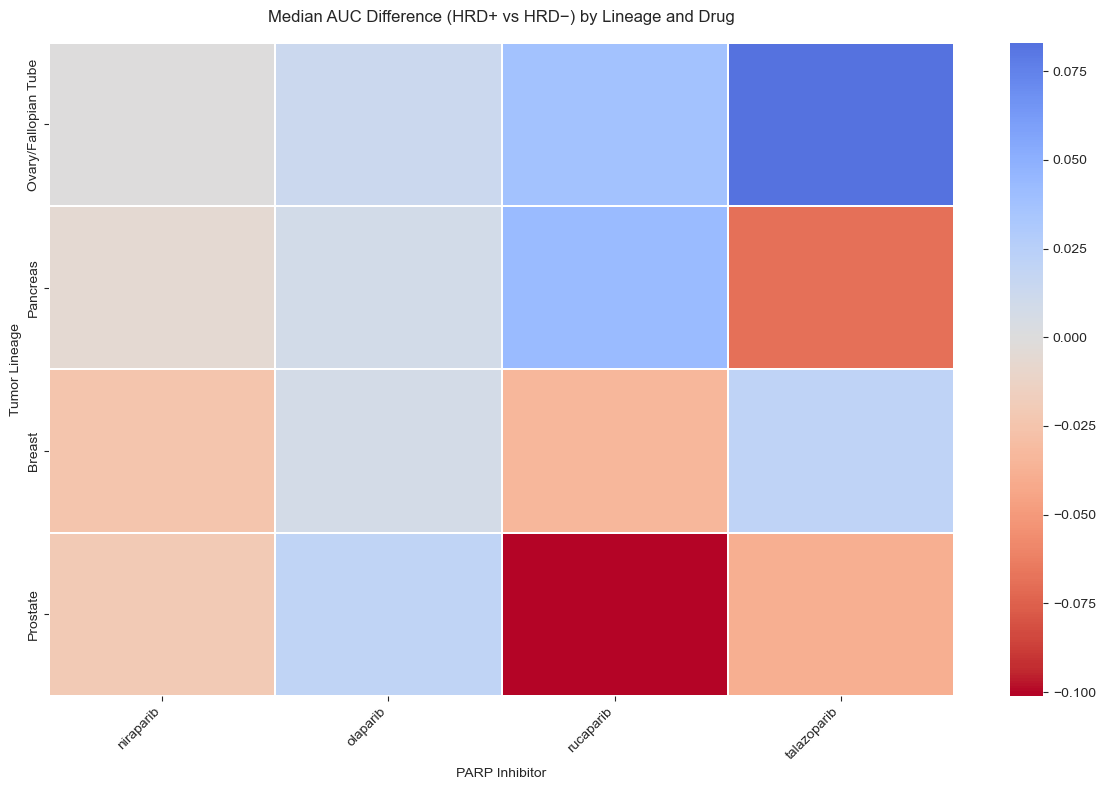

In [19]:
# Desired order
drug_order = ['olaparib', 'rucaparib', 'niraparib', 'talazoparib']
lineage_order = ['Breast', 'Ovary/Fallopian Tube', 'Pancreas', 'Prostate']

# Pivot results into lineage x drug matrix
heatmap_df = (
    drug_lineage_hrd_df
    .pivot(index='lineage', columns='drug', values='delta_median')
)

# Order lineages by number of models (for readability)
lineage_order = (
    ccl_hrd_parpi_df['OncotreeLineage']
    .value_counts()
    .loc[heatmap_df.index]
    .sort_values(ascending=False)
    .index
)
heatmap_df = heatmap_df.loc[lineage_order]


# Set up figure
plt.figure(figsize=(12, 8))

# Plot heatmap
ax = sns.heatmap(
    heatmap_df,
    cmap='coolwarm_r',
    center=0,
    linewidths=0.3,
    linecolor='white',
    annot=False
)

# Labels and formatting
ax.set_title('Median AUC Difference (HRD+ vs HRD−) by Lineage and Drug', pad=15)
ax.set_xlabel('PARP Inhibitor')
ax.set_ylabel('Tumor Lineage')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The heatmap displays lineage-stratified differences in drug response between HRD-positive and HRD-negative models. Each cell represents the median AUC shift (HRD+ minus HRD−) for a given tumor type and PARP inhibitor.

Red values indicate greater sensitivity among HRD-positive models, whereas blue values indicate the opposite. The heterogeneous pattern across tissues shows that the influence of HRD is not uniform. In several cancers HRD status aligns with increased sensitivity, while in others the separation is minimal or even reversed (i.e., Talazoparib & Ovary/Fallopian Tube).

This variability reinforces that pooled analyses can obscure important biological structure and motivates lineage-aware modeling strategies in subsequent sections.

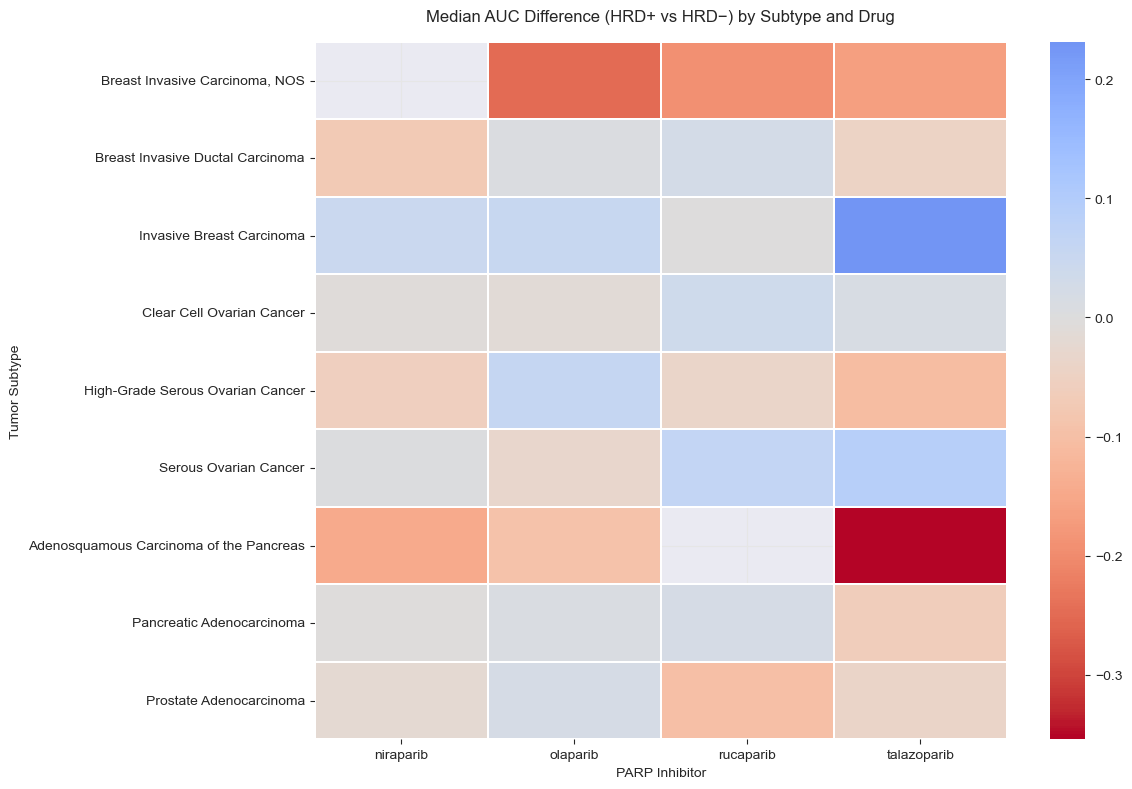

In [20]:
# Minimum models per group to run a test
min_group_size = 1  # including all heatmap
results = []

# Group by drug and subtype
for (drug, subtype), subset_df in ccl_hrd_parpi_df.groupby(
    ['PARP_inhibitor', 'OncotreeSubtype'], observed=True
):
    hrd_neg = subset_df[subset_df['HRD_status'] == 0]['AUC']
    hrd_pos = subset_df[subset_df['HRD_status'] == 1]['AUC']
    
    if len(hrd_neg) >= min_group_size and len(hrd_pos) >= min_group_size:
        stat, p_value = mannwhitneyu(hrd_neg, hrd_pos, alternative='two-sided')
    else:
        p_value = np.nan

    results.append({
        'drug': drug,
        'subtype': subtype,
        'lineage': subset_df['OncotreeLineage'].iloc[0],  # Capture parent lineage
        'n_HRD_neg': len(hrd_neg),
        'n_HRD_pos': len(hrd_pos),
        'median_HRD_neg': hrd_neg.median() if len(hrd_neg) else np.nan,
        'median_HRD_pos': hrd_pos.median() if len(hrd_pos) else np.nan,
        'delta_median': hrd_pos.median() - hrd_neg.median()
        if len(hrd_neg) and len(hrd_pos) else np.nan,
        'p_value': p_value
    })

drug_subtype_hrd_df = pd.DataFrame(results)
drug_subtype_hrd_df = drug_subtype_hrd_df[~drug_subtype_hrd_df.p_value.isna()]

# Pivot into subtype x drug matrix
heatmap_df = drug_subtype_hrd_df.pivot(
    index='subtype', columns='drug', values='delta_median'
)

# Create ordering based on parent lineage first, then subtype within lineage
lineage_order = ['Breast', 'Ovary/Fallopian Tube', 'Pancreas', 'Prostate']
heatmap_df['lineage_order'] = heatmap_df.index.map(
    lambda st: drug_subtype_hrd_df.loc[drug_subtype_hrd_df['subtype']==st, 'lineage'].iloc[0]
)
heatmap_df = heatmap_df.sort_values(
    by=['lineage_order', 'subtype'], ascending=True
)
heatmap_df = heatmap_df.drop(columns='lineage_order')  # Remove helper column

# Plot heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    heatmap_df,
    cmap='coolwarm_r',  
    center=0,
    linewidths=0.3,
    linecolor='white',
    annot=False
)
ax.set_title('Median AUC Difference (HRD+ vs HRD−) by Subtype and Drug', pad=15)
ax.set_xlabel('PARP Inhibitor')
ax.set_ylabel('Tumor Subtype')
plt.tight_layout()
plt.show()

Although breaking down each lineage into subtypes did not materially alter the overall statistical significance of HRD effects, it revealed nuanced patterns in AUC differences between HRD+ and HRD− models. For most tumor types, the delta in median AUC remained small, indicating limited global shifts in sensitivity at the subtype level.

Interestingly, some subtypes exhibited deviations from the expected trend. For example, Invasive Breast Carcinoma showed a positive delta for Talazoparib (HRD+ median AUC > HRD− median AUC), suggesting that HRD+ cells in this subtype were slightly less sensitive than their HRD− counterparts. Other breast subtypes, and ovarian subtypes like High-Grade Serous Ovarian Cancer, displayed modest negative or near-zero deltas, reflecting minor increases in sensitivity or negligible differences.

These observations indicate that while HRD status broadly informs PARP inhibitor response, the effect can be context-dependent at the subtype level, highlighting the value of stratifying by finer histological resolution when exploring lineage-specific vulnerabilities. The heatmap emphasizes that subtypes within the same primary lineage may differ subtly in HRD-associated drug response, even when the overall lineage effect is minimal.

## 5. Quantifying the HRD–PARPi Association 📊

**Objective**: Formally evaluate the magnitude and reliability of the relationship between HRD status and PARP inhibitor response using statistical effect size calculations and regression-based modeling.

**Methodology**: First, global PRISM AUC values are split by HRD-positive and HRD-negative cell lines, and nonparametric tests (Mann–Whitney U) along with Cliff’s delta are computed to assess overall differences in sensitivity. Second, per-drug analyses are conducted to evaluate HRD-associated effects for each PARP inhibitor individually. Third, lineage-stratified comparisons are performed to determine whether HRD effects are consistent across tumor types. Finally, multivariate OLS regression models are fitted incorporating HRD status, drug identity, and tissue lineage to quantify partial contributions to drug response variance. 

---

### 5a. Global Effect Size (HRD+ vs HRD−)

In [21]:
# Split groups
hrd_pos = ccl_hrd_parpi_df.loc[ccl_hrd_parpi_df['HRD_status'] == 1, 'AUC']
hrd_neg = ccl_hrd_parpi_df.loc[ccl_hrd_parpi_df['HRD_status'] == 0, 'AUC']

# Mann–Whitney U
u_stat, p_value = mannwhitneyu(hrd_neg, hrd_pos, alternative='two-sided')

# Cliff's Delta
# probability(pos > neg) - probability(neg > pos)
greater = sum(p > n for p in hrd_pos for n in hrd_neg)
less = sum(p < n for p in hrd_pos for n in hrd_neg)
cliffs_delta = (greater - less) / (len(hrd_pos) * len(hrd_neg))

print('--- Global HRD Effect ---')
print(f'Median HRD- : {np.median(hrd_neg):.4f}')
print(f'Median HRD+ : {np.median(hrd_pos):.4f}')
print(f'Mann-Whitney p-value: {p_value:.4e}')
print(f"Cliff's delta: {cliffs_delta:.4f}")

--- Global HRD Effect ---
Median HRD- : 0.8652
Median HRD+ : 0.8750
Mann-Whitney p-value: 9.3600e-01
Cliff's delta: 0.0048


A non-parametric comparison was performed between HRD+ and HRD− models across the full PARP inhibitor panel. Median AUC values were nearly identical between groups (HRD−: 0.8652; HRD+: 0.8750), indicating minimal shift in overall response. Consistently, the Mann–Whitney U test did not detect a significant difference (p = 0.936), and Cliff’s delta was effectively zero (0.0048), reflecting a negligible effect size. These results suggest that, when considering all compounds collectively, HRD status alone does not produce a strong or consistent separation in PARP inhibitor sensitivity across the screened models.

### 5b. Linear Regression 

In [22]:
# Fit model
reg_model = smf.ols('AUC ~ HRD_status', data=ccl_hrd_parpi_df).fit()

print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    AUC   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                 3.957e-07
Date:                Thu, 26 Feb 2026   Prob (F-statistic):              0.999
Time:                        15:34:24   Log-Likelihood:                 202.50
No. Observations:                 376   AIC:                            -401.0
Df Residuals:                     374   BIC:                            -393.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8270      0.010     82.185      0.0

A simple linear regression was fitted to quantify the effect of HRD status on PARP inhibitor response across all models. The estimated coefficient for HRD status was effectively zero (9.2e-6) and not statistically significant (p = 0.999), confirming that HRD+ and HRD− groups do not differ meaningfully in mean AUC across the full panel. The model explained virtually none of the variance in response (R2 = 0), reinforcing the conclusion that HRD status alone is a poor predictor of overall PARP inhibitor sensitivity when compounds are pooled in this curated cohort.

### 5c. Multivariate Modeling

In [23]:
# Formally assign categorical variables
ccl_hrd_parpi_df['PARP_inhibitor'] = ccl_hrd_parpi_df['PARP_inhibitor'].astype('category')
ccl_hrd_parpi_df['OncotreeLineage'] = ccl_hrd_parpi_df['OncotreeLineage'].astype('category')

# Fit multivariable linear model
multivar_model = smf.ols(
    formula='AUC ~ HRD_status + PARP_inhibitor + OncotreeLineage',
    data=ccl_hrd_parpi_df
).fit()

# Display results
multivar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    AUC   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     52.24
Date:                Thu, 26 Feb 2026   Prob (F-statistic):           1.84e-51
Time:                        15:34:24   Log-Likelihood:                 332.22
No. Observations:                 376   AIC:                            -648.4
Df Residuals:                     368   BIC:                            -617.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   0.8634      0.016     54.342      0.000       0.832       0.895
PARP_inhibitor[T.olaparib]                  0.0367      0.015      2.503      0.013       0.008       0.065
PARP_inhibitor[T.rucaparib]                 0.0440      0.016      2.832      0.005       0.013       0.075
PARP_inhibitor[T.talazoparib]              -0.1861      0.014    -12.917      0.000      -0.214      -0.158
OncotreeLineage[T.Ovary/Fallopian Tube]    -0.0340      0.014     -2.447      0.015      -0.061      -0.007
OncotreeLineage[T.Pancreas]                 0.0245      0.014      1.752      0.081      -0.003       0.052
OncotreeLineage[T.Prostate]                 0.0310      0.028      1.091      0.276      -0.025       0.087
HRD_status                                 -0.0009      0.011     -0.084      0.933      -0.023       0.021
==============================================================================
Omnibus:                       17.532   Durbin-Watson:                   1.442
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.662
Skew:                          -0.265   Prob(JB):                     8.08e-08
Kurtosis:                       4.343   Cond. No.                         7.64
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

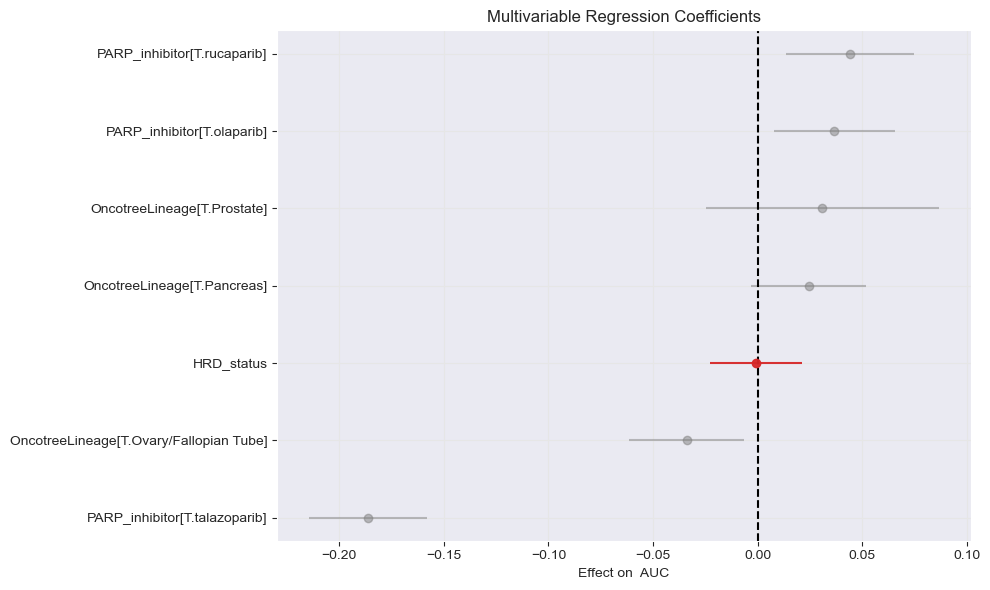

In [24]:
# Extract coefficients and confidence intervals
coef_df = (
    multivar_model.params
    .to_frame(name='coef')
    .join(multivar_model.conf_int())
)

coef_df.columns = ['coef', 'ci_lower', 'ci_upper']
coef_df = coef_df.reset_index().rename(columns={'index': 'term'})

# Remove intercept
coef_df = coef_df[coef_df['term'] != 'Intercept']

# Sort by effect size
coef_df = coef_df.sort_values('coef')

# Plot the coefficients
plt.figure(figsize=(10, 6))

for _, row in coef_df.iterrows():
    
    highlight = row['term'] == 'HRD_status'
    color = '#D62728' if highlight else 'gray'
    
    plt.errorbar(
        x=row['coef'],
        y=row['term'],
        xerr=[[row['coef'] - row['ci_lower']], [row['ci_upper'] - row['coef']]],
        fmt='o',
        color=color,
        ecolor=color,
        alpha=0.95 if highlight else 0.5
    )

# Formatting & Labels
plt.axvline(0, linestyle='--', color='black')
plt.xlabel('Effect on  AUC')
plt.ylabel('')
plt.title('Multivariable Regression Coefficients')
plt.tight_layout()
plt.show()

A multivariable linear regression was conducted to disentangle the contributions of HRD status, PARP inhibitor identity, and tumor lineage on AUC. The model explained nearly half of the variance in response (R2 = 0.498), reflecting substantial differences across drugs and, to a lesser extent, lineages. Drug identity showed the largest effects: Talazoparib responses were significantly lower than the reference (coefficient = –0.186, p < 0.001), whereas Olaparib and Rucaparib showed modestly higher AUCs. Lineage effects were smaller; for example, ovarian/fallopian tube models were slightly more sensitive than breast (–0.034, p = 0.015), while pancreas and prostate were not statistically different. Importantly, HRD status had no detectable effect on response after accounting for drug and lineage (coefficient = –0.001, p = 0.933), indicating that HRD alone does not meaningfully predict PARP inhibitor sensitivity in this cohort when these covariates are considered.

## 6. Summary & Export 💾 

---
---

In [25]:
# Export main curated dataset with PRISM AUC, HRD, and metadata
ccl_hrd_parpi_df.to_pickle(BASE_DIR / 'utils' / 'ccl_hrd_parpi_df.pkl')

# Export drug dispersion summary table
drug_dispersion_df.to_pickle(BASE_DIR / 'utils' / 'drug_dispersion_df.pkl')

# Export per-drug HRD comparison results
per_drug_results_df.to_pickle(BASE_DIR / 'utils' / 'per_drug_results_df.pkl')

# Export lineage-stratified HRD effect table
drug_lineage_hrd_df.to_pickle(BASE_DIR / 'utils' / 'drug_lineage_hrd_df.pkl')

#### Conclusions

This project systematically evaluated the relationship between homologous recombination deficiency (HRD) and PARP inhibitor response across a broad panel of cancer cell lines. Key findings include:

- **HRD Prevalence**: HRD+ models are concentrated in breast, ovarian/fallopian tube, and pancreatic lineages, with lower representation in prostate and other lineages. This reflects lineage-specific enrichment and highlights where statistical power is strongest for HRD–drug analyses. 
- **Drug Response Patterns**: Across the four major PARP inhibitors, Talazoparib displayed the largest dynamic range and highest sensitivity in responsive models, whereas Olaparib, Rucaparib, and Niraparib exhibited more moderate variability. Mean and median AUCs were largely similar between HRD+ and HRD– models at the global level. This showed that PARP inhibitor efficacy is strongly drug/lineage-dependent.
- **HRD Association with Sensitivity**: Non-parametric testing and effect size calculations (Cliff’s delta) revealed negligible differences between HRD+ and HRD– groups across the panel. Subgroup analyses by drug and lineage also failed to identify consistent HRD-driven sensitivity patterns. Multivariable regression confirmed that, after adjusting for drug identity and lineage, HRD status alone does not significantly predict response.
HRD status alone was insufficient as a universal biomarker for response across diverse lineages.
- **Drug Response Across Lineage Subtypes**: Subtype-level analysis largely confirmed the lineage-level trends but revealed subtle heterogeneity within lineages. Notably, Talazoparib responses in invasive breast and adenosquamous pancreatic subtypes showed slight deviations, highlighting potential context-specific variability in HRD-associated sensitivity that warrants further investigation.

While HRD captures an important biological vulnerability, in this curated dataset across *in vitro* cell lines, its predictive power is modest when considering established differences in drug response and lineage context. As outlined in the [original study](https://pmc.ncbi.nlm.nih.gov/articles/PMC10847511/), there could be external factors that are contributing to the discrepancy between the clinical and cell culture results. The lack of a strong association may reflect confounding by drug potency, differential lineage susceptibility, or incomplete capture of functional HRD beyond genomic annotations.


In future iterations of this project, it would be helpful to:

- Incorporate canonical HRD labels across these cell lines, or at least integrate additional functional HRD assays (e.g., RAD51 foci formation) to complement genomic scar and mutational signature metrics.
- Explore combinatorial biomarkers, integrating HRD with gene expression, replication stress markers, or DNA damage response signatures.
- Check for any published analyses in patient-derived xenografts or clinical cohorts to validate *in vitro* observations and improve translational relevance.

Nonetheless, this baseline study establishes a foundation for lineage and drug-aware evaluation of PARP inhibitor sensitivity and shows the importance of multivariable modeling when interpreting biomarker effects.